# Word Segmentation Error Analysis

Copyright (c) 2021 Herman Kamper, MIT License

## Preliminaries

In [1]:
%matplotlib inline
from collections import Counter
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pylab as plt
import sys

sys.path.append("..")

from eval_segmentation import (
    boundaries_to_intervals, intervals_to_boundaries, score_boundaries,
    score_word_token_boundaries, get_os, get_rvalue, get_intervals_from_dir,
    str_to_id_labels    
    )
from plotting import setup_plot

## DPDP data

In [2]:
# Dataset and model
dataset = "buckeye"
split = "test"
model = "cpc_big"
seg_tag = "wordseg_dpdp_aernn_dp_penalized"
# model = "eskmeans"
# seg_tag = "eskmeans"

# Directories
seg_dir = Path("../exp")/model/dataset/split/seg_tag/"intervals"
# phone_ref_dir = Path("../data")/dataset/"phone_intervals"
word_ref_dir = Path("../data")/dataset/"word_intervals"

In [3]:
# Read segmentation
segmentation_interval_dict = {}
print("Reading: {}".format(seg_dir))
assert seg_dir.is_dir(), "missing directory: {}".format(seg_dir)
segmentation_interval_dict = get_intervals_from_dir(seg_dir)
utterances = segmentation_interval_dict.keys()

# Read word reference
if word_ref_dir.is_dir():
    print("Reading: {}".format(word_ref_dir))
    word_ref_interval_dict = get_intervals_from_dir(
        word_ref_dir, utterances
        )

  0%|          | 0/21498 [00:00<?, ?it/s]

Reading: ../exp/cpc_big/buckeye/test/wordseg_dpdp_aernn_dp_penalized/intervals


  0%|          | 0/21498 [00:00<?, ?it/s]

Reading: ../data/buckeye/word_intervals


100%|██████████| 21498/21498 [04:04<00:00, 87.82it/s] 


In [4]:
# Convert intervals to boundaries
print("Converting intervals to boundaries:")
segmentation_boundaries_dict = {}
for utt_key in tqdm(segmentation_interval_dict):
    segmentation_boundaries_dict[utt_key] = intervals_to_boundaries(
        segmentation_interval_dict[utt_key]
        )
if word_ref_dir.is_dir():
    word_ref_boundaries_dict = {}
    for utt_key in tqdm(word_ref_interval_dict):
        word_ref_boundaries_dict[utt_key] = intervals_to_boundaries(
            word_ref_interval_dict[utt_key]
            )

# Map e.g. "23_12_" to a unique integer ID e.g. 10
# if ("word" in seg_tag and "_" in
#         list(segmentation_interval_dict.values())[0][0][-1]):
segmentation_interval_dict, str_to_id, id_to_str = str_to_id_labels(
    segmentation_interval_dict
    )

100%|██████████| 21498/21498 [00:00<00:00, 327844.89it/s]


Converting intervals to boundaries:


## DPDP Evaluation

In [5]:
word_tolerance = 2  # to-do

# Evaluate word boundaries
reference_list = []
segmentation_list = []
word_type_list = []
for utterance in sorted(word_ref_boundaries_dict):
    reference_list.append(word_ref_boundaries_dict[utterance])
    segmentation_list.append(segmentation_boundaries_dict[utterance])
    word_type_list.append([i[2] for i in word_ref_interval_dict[utterance]])
p, r, f = score_boundaries(
    reference_list, segmentation_list, tolerance=word_tolerance
    )

print("-"*(79 - 4))
print("Word boundaries:")
print("Precision: {:.2f}%".format(p*100))
print("Recall: {:.2f}%".format(r*100))
print("F-score: {:.2f}%".format(f*100))
print("OS: {:.2f}%".format(get_os(p, r)*100))
print("R-value: {:.2f}%".format(get_rvalue(p, r)*100))
print("-"*(79 - 4))

# Word token boundaries
p, r, f = score_word_token_boundaries(
    reference_list, segmentation_list, tolerance=word_tolerance
    )
print("Word token boundaries:")
print("Precision: {:.2f}%".format(p*100))
print("Recall: {:.2f}%".format(r*100))
print("F-score: {:.2f}%".format(f*100))
print("OS: {:.2f}%".format(get_os(p, r)*100))
# print("R-value: {:.2f}%".format(get_rvalue(p, r)*100))
print("-"*(79 - 4))

---------------------------------------------------------------------------
Word boundaries:
Precision: 35.30%
Recall: 37.66%
F-score: 36.44%
OS: 6.68%
R-value: 44.25%
---------------------------------------------------------------------------
Word token boundaries:
Precision: 24.40%
Recall: 25.59%
F-score: 24.98%
OS: 4.88%
---------------------------------------------------------------------------


## DPDP finer-grained evaluation

In [6]:
def score_word_token_boundaries_analysis(ref, seg, word_types, tolerance=0):
    """
    Calculate precision, recall, F-score for the word token boundaries.

    Parameters
    ----------
    ref : list of vector of bool
        The ground truth reference.
    seg : list of vector of bool
        The segmentation hypothesis.
    tolerance : int
        The number of slices with which a boundary might differ but still be
        regarded as correct.

    Return
    ------
    output : (float, float, float)
        Precision, recall, F-score.
    """
    # Error statistics
    correct_gt_durations = []
    incorrect_gt_durations = []
#     n_missed_bound = 0
#     n_extra_bound = 0
    correct_tokens = []
    
    # Metric statistics
    n_tokens_ref = 0
    n_tokens_seg = 0
    n_tokens_correct = 0
    
    for i_boundary, boundary_ref in enumerate(ref):
        boundary_seg = seg[i_boundary]
        assert boundary_ref[-1]  # check if last boundary is True
        assert boundary_seg[-1]
        cur_word_types = word_types[i_boundary][:]
        
        # If reference is longer, truncate
        if len(boundary_ref) > len(boundary_seg):
            boundary_ref = boundary_ref[:len(boundary_seg)]
            boundary_ref[-1] = True

        # Build list of ((word_start_lower, word_start_upper), (word_end_lower,
        # word_end_upper))
        word_bound_intervals = []
        for word_start, word_end in boundaries_to_intervals(boundary_ref):
            word_bound_intervals.append((
                (max(0, word_start - tolerance), word_start + tolerance),
                (word_end - tolerance, word_end + tolerance)
                ))
        ref_intervals = boundaries_to_intervals(boundary_ref)
        seg_intervals = boundaries_to_intervals(boundary_seg)
#         print(f"{boundary_ref=}")
#         print(f"{word_bound_intervals=}")
#         print(f"{seg_intervals=}")

        n_tokens_ref += len(word_bound_intervals)
        n_tokens_seg += len(seg_intervals)

        # Score word token boundaries
        for seg_start, seg_end in seg_intervals:
            correct = False
            # print seg_start, seg_end
            for i_gt_word, (word_start_interval,
                    word_end_interval) in enumerate(word_bound_intervals):
                word_start_lower, word_start_upper = word_start_interval
                word_end_lower, word_end_upper = word_end_interval

                if (word_start_lower <= seg_start <= word_start_upper and
                        word_end_lower <= seg_end <= word_end_upper):
                    n_tokens_correct += 1
                    
#                     print("correct")
                    start, end = ref_intervals[i_gt_word]
                    correct_gt_durations.append(end - start)
                    correct_tokens.append(cur_word_types[i_gt_word])
                    
#                     print(ref_intervals[i_gt_word])
#                     print(word_bound_intervals[i_gt_word])
#                     print(cur_word_types[i_gt_word])
    
                    word_bound_intervals.pop(i_gt_word)  # can't re-use token
                    ref_intervals.pop(i_gt_word)
                    cur_word_types.pop(i_gt_word)
                    correct = True
                    break
            if correct:
                continue
#             print("-"*74)
#             print(f"incorrect: {seg_start, seg_end=}")
#             for i_gt_word, (word_start_interval,
#                     word_end_interval) in enumerate(word_bound_intervals):
#                 word_start_lower, word_start_upper = word_start_interval
#                 word_end_lower, word_end_upper = word_end_interval
#                 if word_start_lower <= seg_start <= word_end_lower:
#                     print(f"{word_start_interval=}")
#                     if seg_end > word_end_upper:
#                         n_missed_bound += 1
#                         print("missed")
#                     else:
#                         n_extra_bound += 1
#                         print("extra")
#                     break
#             print("-"*74)
        
        for interval in ref_intervals:
            start, end = interval
            incorrect_gt_durations.append(end - start)
#         print(f"{ref_intervals=}")
#         print("-"*74)

#     # Temp
#     print("n_tokens_correct", n_tokens_correct)
#     print("n_tokens_seg", n_tokens_seg)
#     print("n_tokens_ref", n_tokens_ref)
#     print(f"{correct_gt_durations=}")
#     print(f"{incorrect_gt_durations=}")

    precision = float(n_tokens_correct)/n_tokens_seg
    recall = float(n_tokens_correct)/n_tokens_ref
    if precision + recall != 0:
        f = 2*precision*recall / (precision + recall)
    else:
        f = -np.inf

    analysis_dict = {
        "correct_gt_durations": correct_gt_durations,
        "incorrect_gt_durations": incorrect_gt_durations,
        "correct_tokens": correct_tokens
        }
        
    return precision, recall, f, analysis_dict

In [7]:
word_tolerance = 2
p, r, f, dpdp_analysis = score_word_token_boundaries_analysis(
    reference_list, segmentation_list, word_type_list, tolerance=word_tolerance
    )
print(f"Prec: {p*100:.2f}, Rec: {r*100:.2f}, F1: {f*100:.2f}")

Prec: 24.40, Rec: 25.59, F1: 24.98


In [8]:
print(
    "Correct durations: {:.2f} +- {:.2f} frames".format(
        np.mean(dpdp_analysis["correct_gt_durations"]),
        np.std(dpdp_analysis["correct_gt_durations"])
        )
    )
print(
    "Incorrect durations: {:.2f} +- {:.2f} frames".format(
        np.mean(dpdp_analysis["incorrect_gt_durations"]),
        np.std(dpdp_analysis["incorrect_gt_durations"])
        )
    )

Correct durations: 23.10 +- 11.46 frames
Incorrect durations: 23.64 +- 16.41 frames


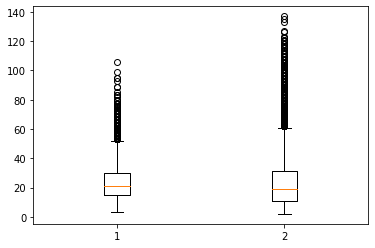

In [9]:
fig1, ax1 = plt.subplots()
data = [
    dpdp_analysis["correct_gt_durations"],
    dpdp_analysis["incorrect_gt_durations"],
    ]
ax1.boxplot(data);

In [10]:
# Word type analysis
word_tokens_ref = [i for sublist in word_type_list for i in sublist]
word_tokens_seg = dpdp_analysis["correct_tokens"]
word_tokens_ref_counter = Counter(word_tokens_ref)
word_tokens_seg_counter = Counter(word_tokens_seg)

In [11]:
normalized_seg_counts = Counter()
for word_type in word_tokens_seg_counter:   
#     if word_type == "okay":
#         print(normalized_seg_counts[word_type])
#         print()
    if word_tokens_ref_counter[word_type] > 10:
        normalized_seg_counts[word_type] = (
            word_tokens_seg_counter[word_type] /
            word_tokens_ref_counter[word_type]
            )

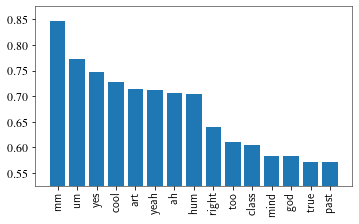

In [18]:
n = 15
most_common_seg = normalized_seg_counts.most_common(n)
plt.bar(
    np.arange(n),
#     [i[0] for i in most_common_seg],
    [i[1] for i in most_common_seg]
    )
plt.xticks(
    np.arange(n),
    [i[0] for i in most_common_seg],
    rotation="vertical"
    )
plt.ylim([0.525, 0.875])
plt.show()

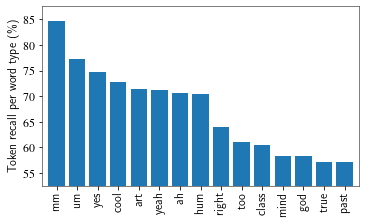

In [13]:
setup_plot()
plt.rcParams["figure.figsize"]          = 5, 3
plt.rcParams["font.sans-serif"]         = "Times"
plt.rcParams["figure.subplot.bottom"]   = 0.16
plt.rcParams["figure.subplot.left"]     = 0.11
plt.rcParams["figure.subplot.right"]    = 0.99
plt.rcParams["figure.subplot.top"]      = 0.99

n = 15
most_common_seg = normalized_seg_counts.most_common(n)
plt.bar(
    np.arange(n),
#     [i[0] for i in most_common_seg],
    [i[1]*100 for i in most_common_seg]
    )
plt.xticks(
    np.arange(n),
    [i[0] for i in most_common_seg],
    rotation="vertical"
    )
plt.ylim([52.5, 87.5])
plt.xlim([-0.7, n - 0.3])
plt.ylabel("Token recall per word type (\%)")
plt.savefig("per_word_recall_top.pdf")
plt.show()

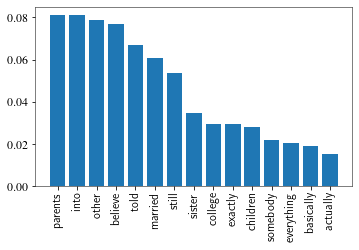

In [39]:
n = 15
# least_common_seg = normalized_seg_counts.most_common()[-n:]
least_common_seg = [i for i in normalized_seg_counts.most_common() if word_tokens_ref_counter[i[0]] > 27][-n:]
plt.bar(
    np.arange(n),
#     [i[0] for i in most_common_seg],
    [i[1] for i in least_common_seg]
    )
plt.xticks(
    np.arange(n),
    [i[0] for i in least_common_seg],
    rotation="vertical"
    )
# plt.ylim([0.0, 0.05])
plt.show()

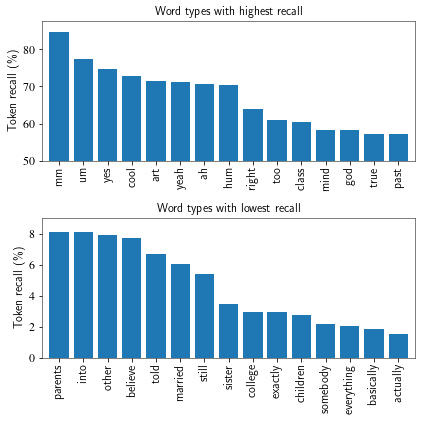

In [92]:
setup_plot()
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.sans-serif"]         = "Times"
# plt.rcParams["axes.titlesize"]          = "large"
# plt.rcParams["figure.subplot.bottom"]   = 0.16
# plt.rcParams["figure.subplot.left"]     = 0.11
# plt.rcParams["figure.subplot.right"]    = 0.99
# plt.rcParams["figure.subplot.top"]      = 0.99

n = 15
most_common_seg = normalized_seg_counts.most_common(n)
least_common_seg = [i for i in normalized_seg_counts.most_common() if word_tokens_ref_counter[i[0]] > 27][-n:]

fig = plt.figure()
plt.subplot(2, 1, 1)
plt.title("Word types with highest recall")
plt.bar(
    np.arange(n),
#     [i[0] for i in most_common_seg],
    [i[1]*100 for i in most_common_seg]
    )
plt.xticks(
    np.arange(n),
    [i[0] for i in most_common_seg],
    rotation="vertical"
    )
plt.ylim([50, 87.5])
plt.xlim([-0.7, n - 0.3])
# plt.ylabel("Token recall per word type (\%)")
plt.ylabel("Token recall (\%)")
# plt.savefig("per_word_recall_top.pdf")

plt.subplot(2, 1, 2)
plt.title("Word types with lowest recall")
plt.bar(
    np.arange(n),
#     [i[0] for i in most_common_seg],
    [i[1]*100 for i in least_common_seg]
    )
plt.xticks(
    np.arange(n),
    [i[0] for i in least_common_seg],
    rotation="vertical"
    )
plt.xlim([-0.7, n - 0.3])
plt.ylim([0, 9])
plt.ylabel("Token recall (\%)")
# plt.ylabel("Token recall per word type (\%)")

fig.tight_layout(pad=1.0)

plt.savefig("per_word_recall_top_bottom.pdf")

plt.show()

## ES-KMeans data

ES-KMeans output obtained from: 

    /media/kamperh/endgame/projects/stellenbosch/bucktsong_eskmeans/segmentation/kmodels/zs/mfcc.n_10.unsup_syl/sd_8acab507e2/models.txt`

In [14]:
# Dataset and model
dataset = "buckeye"
split = "test"
# model = "cpc_big"
# seg_tag = "wordseg_dpdp_aernn_dp_penalized"
model = "eskmeans"
seg_tag = "eskmeans"

# Directories
seg_dir = Path("../exp")/model/dataset/split/seg_tag/"intervals"
# phone_ref_dir = Path("../data")/dataset/"phone_intervals"
word_ref_dir = Path("../data")/dataset/"word_intervals"

In [15]:
# Read segmentation
segmentation_interval_dict = {}
print("Reading: {}".format(seg_dir))
assert seg_dir.is_dir(), "missing directory: {}".format(seg_dir)
segmentation_interval_dict = get_intervals_from_dir(seg_dir)
utterances = segmentation_interval_dict.keys()

# Read word reference
if word_ref_dir.is_dir():
    print("Reading: {}".format(word_ref_dir))
    word_ref_interval_dict = get_intervals_from_dir(
        word_ref_dir, utterances
        )

 19%|█▉        | 4116/21498 [00:00<00:00, 41153.76it/s]

Reading: ../exp/eskmeans/buckeye/test/eskmeans/intervals


  0%|          | 0/21498 [00:00<?, ?it/s]

Reading: ../data/buckeye/word_intervals


100%|██████████| 21498/21498 [00:00<00:00, 35266.43it/s]


In [16]:
# Convert intervals to boundaries
print("Converting intervals to boundaries:")
segmentation_boundaries_dict = {}
for utt_key in tqdm(segmentation_interval_dict):
    segmentation_boundaries_dict[utt_key] = intervals_to_boundaries(
        segmentation_interval_dict[utt_key]
        )
if word_ref_dir.is_dir():
    word_ref_boundaries_dict = {}
    for utt_key in tqdm(word_ref_interval_dict):
        word_ref_boundaries_dict[utt_key] = intervals_to_boundaries(
            word_ref_interval_dict[utt_key]
            )

# Map e.g. "23_12_" to a unique integer ID e.g. 10
# if ("word" in seg_tag and "_" in
#         list(segmentation_interval_dict.values())[0][0][-1]):
segmentation_interval_dict, str_to_id, id_to_str = str_to_id_labels(
    segmentation_interval_dict
    )

100%|██████████| 21498/21498 [00:00<00:00, 326960.43it/s]

Converting intervals to boundaries:


## ES-KMeans finer-grained evaluation

In [17]:
reference_list = []
segmentation_list = []
word_type_list = []
for utterance in sorted(word_ref_boundaries_dict):
    reference_list.append(word_ref_boundaries_dict[utterance])
    segmentation_list.append(segmentation_boundaries_dict[utterance])
    word_type_list.append([i[2] for i in word_ref_interval_dict[utterance]])

word_tolerance = 2
p, r, f, eskmeans_analysis = score_word_token_boundaries_analysis(
    reference_list, segmentation_list, word_type_list, tolerance=word_tolerance
    )
print(f"Prec: {p*100:.2f}, Rec: {r*100:.2f}, F1: {f*100:.2f}")

Prec: 21.70, Rec: 15.18, F1: 17.86


In [18]:
print(
    "Correct durations: {:.2f} +- {:.2f} frames".format(
        np.mean(eskmeans_analysis["correct_gt_durations"]),
        np.std(eskmeans_analysis["correct_gt_durations"])
        )
    )
print(
    "Incorrect durations: {:.2f} +- {:.2f} frames".format(
        np.mean(eskmeans_analysis["incorrect_gt_durations"]),
        np.std(eskmeans_analysis["incorrect_gt_durations"])
        )
    )

Correct durations: 28.61 +- 12.43 frames
Incorrect durations: 22.71 +- 15.66 frames


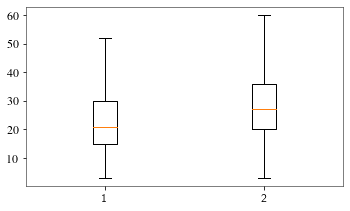

In [19]:
fig1, ax1 = plt.subplots()
data = [
    dpdp_analysis["correct_gt_durations"],
    eskmeans_analysis["correct_gt_durations"],
#     dpdp_analysis["incorrect_gt_durations"],
#     eskmeans_analysis["incorrect_gt_durations"],
    ]
ax1.boxplot(data, showfliers=False);
# ax1.set_ylim([0, 70])

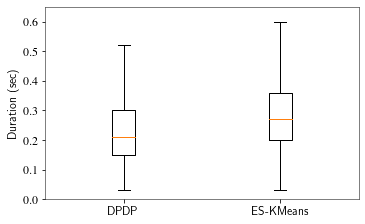

In [36]:
setup_plot()
plt.rcParams["figure.figsize"]          = 5, 3
plt.rcParams["font.sans-serif"]         = "Times"
plt.rcParams["figure.subplot.bottom"]   = 0.1
plt.rcParams["figure.subplot.left"]     = 0.12
plt.rcParams["figure.subplot.right"]    = 0.99
plt.rcParams["figure.subplot.top"]      = 0.99

fig1, ax1 = plt.subplots()
data = [
    np.array(dpdp_analysis["correct_gt_durations"])/100,
    np.array(eskmeans_analysis["correct_gt_durations"])/100,
#     dpdp_analysis["incorrect_gt_durations"],
#     eskmeans_analysis["incorrect_gt_durations"],
    ]
ax1.boxplot(data, showfliers=False);
# ax1.set_ylim([0, 70])
# fig1.xticks([1, 2], )
plt.setp(ax1, xticklabels=["DPDP", "ES-KMeans"])
# plt.setp(["DPDP", "ES-KMeans"], rotation=45, fontsize=8)
plt.ylabel("Duration (sec)")
plt.ylim([0, 0.65])

plt.savefig("dpdp_eskmeans_correct_durations.pdf")